In [1]:
%load_ext autoreload
%autoreload 2

# Running uncertainty-biased molecular dynamics with MACE-MP-0

## Intro and Setup

This notebook illustrates a simple application of the code from this repository using a pre-trained MACE-MP-0 model for uncertainty-biased MD. First, we import some of the required tools and packages and add the `Uncertainty_eABF_GaMD` directory to the system's path.

In [2]:
import os
import sys

# add the directory one level up to the path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

In [3]:
import copy

import matplotlib.pyplot as plt
import nglview
import numpy as np
from ase.io.trajectory import Trajectory
from ase.visualize import ngl
from mace.calculators import mace_mp
from nff.io.ase import AtomsBatch
from nff.md.nvt import Langevin
from nff.md.utils import BiasedNeuralMDLogger

from eabfgamd.mace_calculators import aMDeABF
from eabfgamd.misc import load_from_xyz

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.dpi"] = 150

# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = "cpu"

/home/ajhoffman/miniforge3/envs/uncertainty/lib/python3.11/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices = 

/home/ajhoffman/miniforge3/envs/uncertainty/lib/python3.11/site-packages/models


For this tutorial, we're going to use the smallest version of the pre-trained MACE-MP-0 models. In this case, we need a stable machine-learned interatomic potential (MLIP) from which we can quickly compile latent representations for a structure from which we can estimate uncertainties for a given arrangement of atoms. The bulk of this repository is also structured around the latent representations of the MACE model; as such, the small model is appropriate (and sufficiently fast) for our test here.

In [4]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [5]:
macecalc = mace_mp("small", device=DEVICE)
model = macecalc.models[0]
model = model.to(DEVICE)

2025-05-01 15:51:04,244|INFO|Using CPU


Using Materials Project MACE for MACECalculator with /home/ajhoffman/.cache/mace/20231210mace128L0_energy_epoch249model
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


The structures in this tutorial are derived from studies of aluminum siting in zeolites in the G&oacute;mez-Bombarelli group. We have downselected 200 structures and put them into "training", "validation", and "test" sets; however, these classifications are spurious, as the pre-trained model has not been exposed to any of these datapoints before. Instead, we are using these only to illustrate how a user might use these approaches with a given dataset to sample new structures.

In [6]:
# Load the data from the data directory in this tutorials folder
base_path = "data"
train_path = os.path.join(base_path, "train_atoms_list.xyz")
val_path = os.path.join(base_path, "val_atoms_list.xyz")
test_path = os.path.join(base_path, "test_atoms_list.xyz")
train_atoms = load_from_xyz(train_path)
val_atoms = load_from_xyz(val_path)
test_atoms = load_from_xyz(test_path)

In [7]:
len(train_atoms), len(val_atoms), len(test_atoms)

(160, 20, 20)

## Setting up the MD run

Next, we set up a short MD run based on the calculator and structures grabbed above. We set up a `dict` with information for the MD run. Many of these variables are specified already in [our manuscript](https://doi.org/10.1063/5.0246178) on biasing MD simulations with uncertainty. We believe that many of the items in the dictionary below are self-explanatory (such as the `model` item near the top and the `dset` values near the bottom). The remainder are:
- `"uncertainty_type"`: the type of uncertainty that you wish to use; we _strongly_ recommend `"gmm"` for Gaussian mixture models, which are [effective single-model uncertainty methods]() that are useful for test cases outlined in this work.
- `"uncertainty_params"`: additional parameters for the uncertainty metrics, particularly
    - `"calibrate"`: whether or not to calibrate the uncertainty using the conformal prediction method included in [AmpTorch](https://github.com/ulissigroup/amptorch), which is mentioned in [their attendant publication](https://joss.theoj.org/papers/10.21105/joss.05035) and as a UQ method in [work from the Medford group](https://iopscience.iop.org/article/10.1088/2632-2153/aca7b1). Calibration is extremely helpful for ensuring that the values of the uncertainty estimates from the GMM model remain near consistent and reasonable values&mdash;that is, O(10<sup>&minus;1</sup>)-O(10<sup>+1</sup>).
    - `"cp_alpha"`: the &alpha; value used for the conformal prediction (see above papers).
    - `"order"`: the level at which uncertainty is calculated, the options of which are listed in [the `uncertainty.py` module](https://github.com/learningmatter-mit/Uncertainty_eABF-GaMD/blob/main/eabfgamd/uncertainty.py).

In [8]:
info_dict = {
    "type": "uncertainty",
    "model": model,
    "uncertainty_type": "gmm",
    "uncertainty_params": {
        "calibrate": True,
        "cp_alpha": 0.05,
        "n_components": 5,
        "covariance_type": "full",
        "type": "gmm",
        "embedding_kwargs": {
            "n_rff": 1000,
            "learnable": False,
            "n_hidden": 2,
            "n_units": 100,
            "activation": "swish",
            "dropout": 0.0,
        },
        "quantity": "energy_grad",
        "order": "local_mean_system_max",
        "set_min_uncertainty_at_level": "local",
    },
    "device": DEVICE,
    "batch_size": 4,
    "train_dset": train_atoms,
    "calib_dset": val_atoms,
    "test_dset": test_atoms,
}


For the sake of this exercise, let's simply grab an `Atoms` object from the validation set and run MD on that structure. Typically, you would want to optimize a structure before doing these MD simulations. We will forgo that step here.

In [9]:
atoms = copy.deepcopy(val_atoms[0])

In [10]:
atoms = AtomsBatch.from_atoms(atoms, device=DEVICE)

The values of the uncertainty biasing CV will depend on how the uncertainty is calculated: uncertainty can be calculated locally or system-wide, either using a mean or sum of the uncertainties, etc. The choice of minimum and maximum value in this cell is based on values that have worked for silica simulations in the `configs/silica.yaml` file that were used in the [paper from our group](https://doi.org/10.1063/5.0246178).

In [11]:
min_val = -30.0
max_val = 30.0

In [ ]:
# TODO: need to add more information for the cv_info dictionary

cv_info = {
    "barostat_mask": 1,
    "bin_width": 0.1,
    "collect_pot_samples": True,
    "md_ensemble": "nvt",
    "md_ensemble_params": {
        "temperature": 300,
        "timestep": 1.0,
        "friction": 0.1,
    },
    "ext_mass": 500.0,
    "ext_sigma": 1.0,
    "ext_width": 0.5,
    "conf_k": 10.0,
    "factor": {
        "ext_mass": 1.0,
        "ext_sigma": 0.9,
        "nsteps": 1.2,
        "sampling_llim": 0.9,
        "time_width": 2.5,
    },
    "nsteps": 100,
    "save_dir": "uncertainty",
    "sampling_method": "latent_embedding",
    "sampling_llim": 0.75,
    "sampling_llim_quantile": 0.75,
    "samd_c0": 0.0001,
    "T_init": 300,
    "unphysical_emax": 10000.0,
    "unphysical_emin": -10000.0,
    "ext_pos": None,
}

In [16]:
cv_defs = [
    {
        "definition": info_dict,
        "range": [min_val, max_val],
        "type": "uncertainty",
        **cv_info,
    }
]

my_dt = 1.0  # fs
my_temp = 300  # K
my_friction = 1.0
logfile = "eABF_ext.log"

In [ ]:
# TODO: need to add more information for the calculator and dynamics classes
# and how they are supposed to be called and used in this example

# set the calculator, which is the BiasBase class
calculator = aMDeABF(
    model_path=model,
    cv_defs=cv_defs,
    starting_atoms=atoms,
    dt=my_dt,
    friction_per_ps=my_friction,
    amd_parameter=0.01,
    collect_pot_samples=True,
    estimate_k=True,
    apply_amd=True,
    amd_method="gamd_upper",
    samd_c0=0.0001,
    equil_temp=my_temp,
    nfull=50,
    directed=True,
    device=DEVICE,
)
atoms.set_calculator(calculator)

dyn = Langevin(
    atoms,
    timestep=my_dt,
    temperature=my_temp,
    friction=my_friction,
    maxwell_temp=my_temp,
    logfile=logfile,
    trajectory="eABF_ext.traj",
    # max_steps=10,
    # steps=10,
)
dyn.attach(BiasedNeuralMDLogger(dyn, atoms, logfile, header=True, mode="w"), interval=2)

print("THE RANDOM NUMBER SEED WAS:", np.random.get_state()[1][0])

dyn.run(steps=200)

2025-05-01 13:46:44,423|INFO|Using CPU


Are any atoms positions NaN? False
COLVAR: Doing train prediction


100%|██████████| 160/160 [00:00<00:00, 1040447.50it/s]


COLVAR: Fitting GMM
COLVAR: Fitting ConformalPrediction


100%|██████████| 20/20 [00:00<00:00, 427990.20it/s]


COLVAR: Setting min_uncertainty to -1218.5716079844226
No prediction provided, generating one...


100%|██████████| 1/1 [00:00<00:00, 18724.57it/s]


THE RANDOM NUMBER SEED WAS: 1581724688
THE RANDOM NUMBER SEED WAS: 3557087345


100%|██████████| 10/10 [11:31<00:00, 69.12s/it]


Let's briefly check what the structures from the simulation look like.

**Note**: your ASE installation should have installed `nglview`, which we use here to check the trajectory. If you have issues getting `nglview` to work in your notebook, please check their [GitHub repository](https://github.com/nglviewer/nglview) for up-to-date information and help debugging.

In [13]:
traj = Trajectory("eABF_ext.traj", "r")

In [19]:
# Visualize the trajectory using nglview
view = nglview.show_asetraj(traj)
view.add_unitcell()
view

NGLWidget(max_frame=200)

Let's extract the values of different relevant values from the log file and quickly plot them.

In [17]:
log = np.loadtxt(logfile, skiprows=1)
times = log[:, 0]
biased_ens = log[:, 1]
unbiased_ens = log[:, 2]
cv_val = log[:, 4]

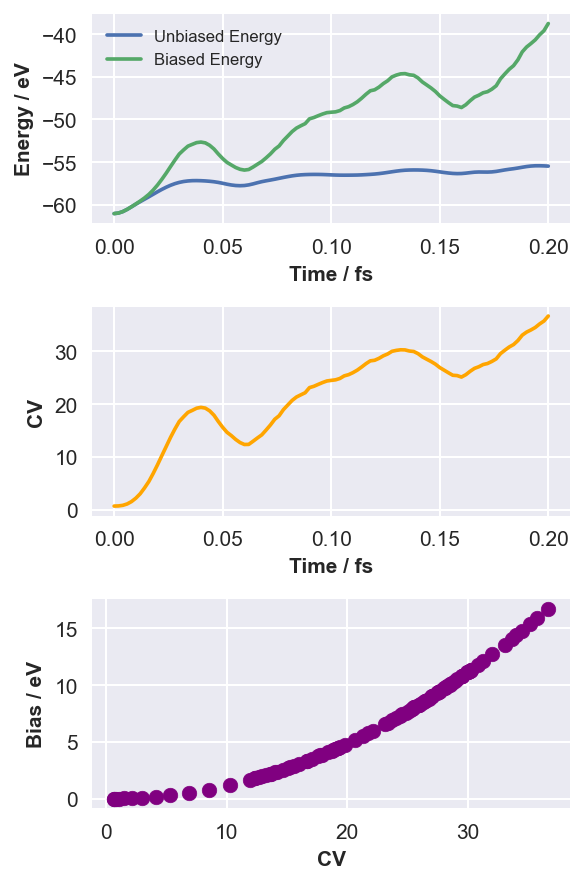

In [18]:
# plot the energies of the trajectory
fig, ax = plt.subplots(3, 1, figsize=(4, 6))

# show the
ax[0].plot(times, unbiased_ens, label="Unbiased Energy")
ax[0].plot(times, biased_ens, label="Biased Energy")
ax[0].set_xlabel("Time / fs", fontweight="bold", fontsize=10)
ax[0].set_ylabel("Energy / eV", fontweight="bold", fontsize=10)
ax[0].legend(loc="upper left", fontsize=8)

ax[1].plot(times, cv_val, label="CV", color="orange")
ax[1].set_xlabel("Time / fs", fontweight="bold", fontsize=10)
ax[1].set_ylabel("CV", fontweight="bold", fontsize=10)

ax[2].scatter(cv_val, biased_ens - unbiased_ens, label="Bias from CV", color="purple")
ax[2].set_xlabel("CV", fontweight="bold", fontsize=10)
ax[2].set_ylabel("Bias / eV", fontweight="bold", fontsize=10)
fig.tight_layout()
plt.show()